# Practical Statistics for Data Scientists (Python)
# Chapter 7. Unsupervised Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

#import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
from collections import Counter

%matplotlib inline

## Selecting the number of clusters

In [19]:
# index_col=0 indica que la primera columna del archivo CSV contiene los índices de las filas.
sp500_px = pd.read_csv(r'./data/sp500_data.csv.gz', index_col=0)

In [22]:
# Se crea un nuevo dataframe que contiene solo las filas a partir del 1 de enero de 2011 de las columnas 'XOM' y 'CVX' del dataframe original 
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]

In [25]:
df.head()

,XOM,CVX
2011-01-03,0.736805,0.240681
2011-01-04,0.168668,-0.584516
2011-01-05,0.026631,0.446985
2011-01-06,0.248558,-0.919751
2011-01-07,0.337329,0.180511


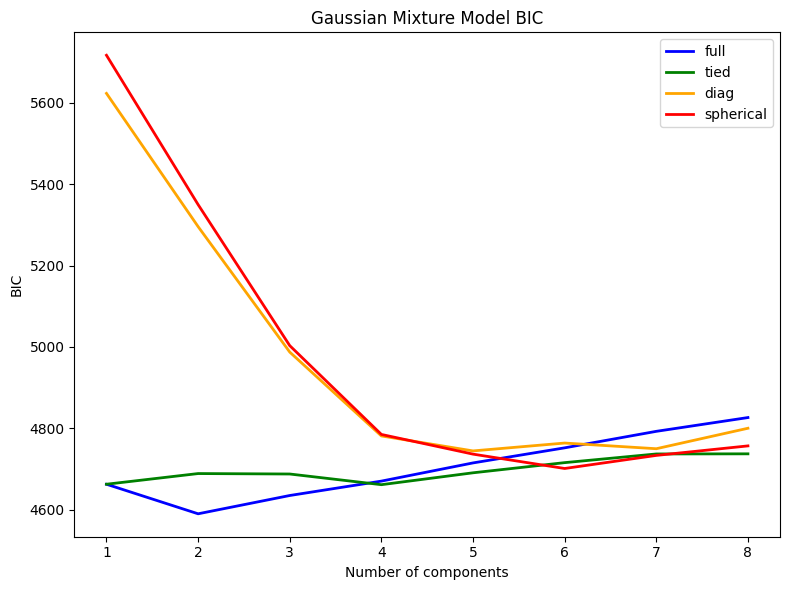

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Cargar los datos
sp500_px = pd.read_csv(r'./data/sp500_data.csv.gz', index_col=0)
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]


# En result se almacenará los resultados de los modelos ajustados.
results = []

# Se define una lista de los diferentes tipos de matrices de covarianza que se utilizarán en los modelos de mezcla de Gaussian.
covariance_types = ['full', 'tied', 'diag', 'spherical']

colors = ['blue', 'green', 'orange', 'red']

#Se crea una figura 
fig, ax = plt.subplots(figsize=(8, 6))

# Se itera para los diferentes tipos de matrices de covarianza
# y en cada tipo se iteran los componentes (de 1 a 8) 


for i, covariance_type in enumerate(covariance_types):
    for n_components in range(1, 9):
        
        # Se crea una instancia del modelo de mezcla de Gaussian con el número de componentes y
        # el tipo de matriz de covarianza especificados anteriormente
        mclust = GaussianMixture(n_components=n_components, warm_start=True, 
                                 covariance_type=covariance_type)
        
        # Se ajusta el modelo a los datos contenidos en el dataframe df
        mclust.fit(df)
        
        #  Se agrega a la lista un diccionario con el BIC, el número de componentes y el tipo de matriz de covarianza 
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type
        })

# Se convierte la lista results en un dataframe
results = pd.DataFrame(results)


# Se itera a través de los diferentes tipos de matrices de covarianza 
# y se traza la curva del BIC en función del número de componentes para cada tipo

for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', color=colors[i], linewidth=2)

ax.set_xlabel('Number of components')
ax.set_ylabel('BIC')
ax.set_title('Gaussian Mixture Model BIC')
ax.legend()
plt.tight_layout()
plt.show()

- Se explora los diferentes modelos de mezcla de Gaussian con diferentes números de componentes y tipos de matrices de covarianza, y luego se  visualiza el criterio de información bayesiano (BIC) para determinar el número óptimo de grupos o componentes en los datos.




- En la gráfica, se puede observar que el BIC parece alcanzar un valor minmo alrededor del 4-6 grupo. Esto sugiere que un modelo de mezcla de Gaussian en el rango de 4-6 componentes podría ser una buena opción para representar la estructura de los datos.

Interpretación de la Gráfica BIC

- Eje X: Muestra el número de grupos considerados en el análisis (del 1 al 8).
- Eje Y: Muestra el valor BIC para cada combinación de grupo y tipo de covarianza. 
- Un valor BIC más bajo indica un mejor equilibrio entre la complejidad del modelo y el ajuste a los datos.
- La gráfica BIC indica que el número de grupo 2 es la mejor opción para modelar los datos.


## Scaling and Categorical Variables
### Scaling the Variables

In [2]:
loan_data = pd.read_csv(r'./data/loan_data.csv.gz', sep=',')


In [39]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         45342 non-null  int64   
 1   status             45342 non-null  object  
 2   loan_amnt          45342 non-null  int64   
 3   term               45342 non-null  object  
 4   annual_inc         45342 non-null  int64   
 5   dti                45342 non-null  float64 
 6   payment_inc_ratio  45342 non-null  float64 
 7   revol_bal          45342 non-null  int64   
 8   revol_util         45342 non-null  float64 
 9   purpose            45342 non-null  object  
 10  home_ownership     45342 non-null  object  
 11  delinq_2yrs_zero   45342 non-null  int64   
 12  pub_rec_zero       45342 non-null  int64   
 13  open_acc           45342 non-null  int64   
 14  grade              45342 non-null  float64 
 15  outcome            45342 non-null  category
 16  emp_

- status: El estado del préstamo
- loan_amnt: El monto del préstamo
- term: Plazo del préstamo
- annual_inc: Ingreso anual del prestatario
- dti: Relación entre la deuda total y el ingreso total
- payment_inc_ratio: Monto del pago del préstamo dividido por el ingreso bruto
- revol_bal: Saldo del crédito revolvente
- revol_util: porcentaje de crédito disponible
- purpose: propósito del préstamo 
- home_ownership: Indica si el prestatario es propietario de una vivienda o alquila.
- delinq_2yrs_zero: Número de cuentas morosas en los últimos 2 años (0 indica ninguna)
- pub_rec_zero: Número de registros públicos (por ejemplo, bancarrotas, juicios, embargos, etc.) en los últimos 10 años (0 indica ninguno)
- open_acc: Número de cuentas abiertas
- grade: Calificación de solvencia crediticia asignada al prestatario por el prestamista
- outcome: 'paid off' (pagado) o 'default' (incumplimiento).
- emp_length: Años de empleo del prestatario
- purpose_, home_, emp_len_: versiones codificadas de variables categóricas

In [8]:
loan_data['outcome'].value_counts()

outcome
default     22671
paid off    22671
Name: count, dtype: int64

In [9]:
loan_data.columns

Index(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length', 'purpose_', 'home_', 'emp_len_',
       'borrower_score'],
      dtype='object')

In [10]:
#La columna 'outcome' se convierte en una variable categórica con dos categorías ordenadas: 'paid off' y 'default'.
# importante para usar el agrupamiento k-means más adelante.

loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [11]:
#creación de un DataFrame "defaults"  que contiene solo las filas donde el resultado es 'default'.
#filtra los casos de incumplimiento

defaults = loan_data.loc[loan_data['outcome'] == 'default',]


In [12]:
defaults['outcome'].value_counts()

outcome
default     22671
paid off        0
Name: count, dtype: int64

In [13]:
#Selección de columnas relevantes para el análisis de agrupamiento.

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]

In [14]:
df.head(10)

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util
0,2500,30000,1687,3,1.00,9.4
1,5600,40000,5210,11,5.55,32.6
2,5375,15000,9279,2,18.08,36.5
3,9000,30000,10452,4,10.08,91.7
4,10000,100000,11997,14,7.06,55.5
5,21000,105000,32135,7,13.22,90.3
6,6000,76000,5963,7,2.40,29.7
7,15000,60000,5872,7,15.22,57.6
8,5000,50004,4345,14,13.97,59.5
9,5000,100000,74351,17,16.33,62.1


### Aplicación del kmeans a un conjunto de datos de impagos de préstamos sin normalizar


In [15]:
# Se aplica el algoritmo K-Means para agrupar los datos. 
# se especifica que se quieren formar 4 grupos (n_clusters=4). 
# Se utiliza un estado aleatorio para la inicialización y se ajusta el número de inicializaciones de forma automática.

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df)

#cuenta el número de observaciones en cada uno de los clusters generados por K-Means.
counts = Counter(kmeans.labels_)


In [17]:
#Se calculan los centroides de los clusters formados y se almacenan en un DataFrame llamado centers.

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  17809.760881   78669.452556  18933.405997  11.594003  17.016428   
1  21444.318867  148736.057263  33152.689572  12.376733  13.831145   
2  24290.909091  409746.465909  84710.988636  13.431818   8.148636   
3  10274.160906   41241.205530   9950.095008   9.480338  17.718588   

   revol_util   size  
0   62.183810   7906  
1   63.151084   1654  
2   60.015647     88  
3   57.903425  13023  


Se realizó un análisis de agrupamiento utilizando el algoritmo K-Means sin escalar las características y a continuacion se escala utilizando la estandarización

### Aplicación de kmeans a los datos normalizados


In [18]:

#Se estandarizan los datos utilizando la clase StandardScaler
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)


# se aplica nuevamente el algoritmo K-Means sobre los datos escalados.
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)

# Se cuentan nuevamente los registros por cluster y se almacenan en el diccionario counts
counts = Counter(kmeans.labels_)

# Se invierte la escala de los centroides de los clusters para que estén en la misma escala que los datos originales
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  13484.728906   55907.993263  16435.803337  14.322265  24.211535   
1  25950.205142  116834.142232  32945.972921  12.396335  16.165914   
2  10507.283093   51117.994063  11635.285252   7.509513  15.931561   
3  10324.846369   53456.824767   6054.819926   8.664618  11.312983   

   revol_util  size  
0   59.463608  6244  
1   66.123542  3670  
2   77.795077  7397  
3   30.999874  5360  


size: Indica el tamaño del cluster, es decir, cuántas observaciones están asignadas a ese cluster en particular. Por ejemplo, en el primer cluster, hay 6244 observaciones, en el segundo 3670, en el tercero 7397 y en el cuarto 5360.

Cuando no se escalas los datos, las variables tienen unidades y magnitudes diferentes, lo que puede afectar la manera en que se agrupan en el algoritmo KMeans.

Para la carcteristica revol_util
el primer conjunto (sin escalar) están en un rango más estrecho (aproximadamente entre 57 y 63), mientras que en el segundo conjunto (escalado), los valores están en un rango más amplio (entre aproximadamente 30 y 77).

Esta diferencia de escala puede influir en la forma en que se calcula la distancia entre los puntos y, por lo tanto, en cómo se forman los clusters. 

## Dominant Variables

In [70]:
sp500_px = pd.read_csv(r'./data/sp500_data.csv.gz', index_col=0)

In [75]:
sp500_px.index 

Index(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03', '1993-02-04',
       '1993-02-05', '1993-02-08', '1993-02-09', '1993-02-10', '1993-02-11',
       ...
       '2015-06-18', '2015-06-19', '2015-06-22', '2015-06-23', '2015-06-24',
       '2015-06-25', '2015-06-26', '2015-06-29', '2015-06-30', '2015-07-01'],
      dtype='object', length=5647)

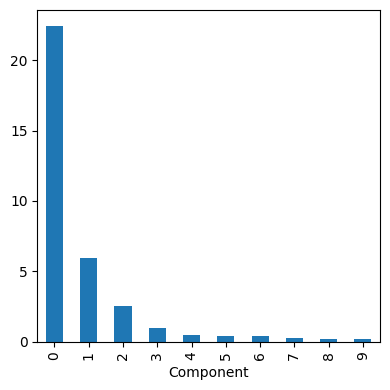

In [76]:
# Entidades a considerar
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']

# Seleccionar los datos de precios de las acciones a partir del 1 de enero de 2005
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

# Inicializar el objeto PCA
sp_pca1 = PCA()

# Ajustar el modelo PCA a los datos seleccionados
# PCA encuentra las direcciones de máxima varianza en los datos y  las transforma en un nuevo 
# conjunto de variables  no correlacionadas llamadas componentes principales
sp_pca1.fit(top_sp1)



# Calcular la varianza explicada por cada componente principal y almacenarla en un DataFrame
# La varianza explicada indica cuánta variabilidad de los datos originales es explicada por cada componente principal.
explained_variance = pd.DataFrame(sp_pca1.explained_variance_)

# Configurar y mostrar el gráfico de barras de la varianza explicada de los primeros 10 componentes principales
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

- Eje X (Componentes): Los componentes están enumerados del 0 al 9. Estos representan los primeros 10 componentes principales obtenidos del PCA.

- Eje Y (Varianza Explicada): La altura de las barras en el histograma representa la cantidad de varianza explicada por cada componente principal. En un PCA, la varianza explicada es una medida de cuánta información de los datos originales está contenida en cada componente principal. 

- Los tres primeros componentes principales (0, 1 y 2) explican la mayor parte de la varianza en los datos.  a partir de 3 en adelante la varianza explicada por cada componente tiende a disminuir, lo que indica que estos componentes capturan menos variabilidad en los datos y pueden considerarse menos importantes en términos de representar la estructura general de los datos.

- Interpretación de los Loadings: En el resultado que has mostrado, para el primer componente principal (columna 0), las variables "GOOGL", "AMZN", "CVX", "XOM", y "SLB" tienen loadings más altos en valor absoluto, lo que sugiere que estas variables son dominantes en el primer componente. Para el segundo componente principal (columna 1), las variables "AMZN", "AAPL", "MSFT", y "INTC" tienen loadings más altos en valor absoluto, lo que indica su dominancia en el segundo componente.

In [77]:
# Crear un DataFrame de loadings usando los dos primeros componentes principales
# selecciona los dos primeros componentes principales. 


loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)

#Se transpone el DataFrame para que los símbolos de las acciones se conviertan en las filas y los componentes principales en las columnas. 
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826



el loading de GOOGL es -0.857310. Esto indica una fuerte correlación negativa con el primer componente principal. En otras palabras, los movimientos de precios de GOOGL tienden a ser inversos o opuestos a la dirección del primer componente

GOOGL es 0.477873. Este valor positivo indica una correlación moderadamente positiva con el segundo componente principal. En otras palabras, los movimientos de precios de GOOGL tienden a seguir en la misma dirección que el segundo componente

## Categorical Data and Gower's Distance
> Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

https://github.com/scikit-learn/scikit-learn/pull/9555/

In [78]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

## Problems with Clustering Mixed Data

In [86]:
#Definir las columnas que se utilizarán para el análisis de agrupación
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']

# Convertir las variables categóricas en variables dummy para manejar la variable categórica 'home_'.
df = pd.get_dummies(defaults[columns])

- dti: Relación entre la deuda total y el ingreso total
- payment_inc_ratio: Monto del pago del préstamo dividido por el ingreso bruto
- home__MORTGAGE, home__OWN, home__RENT: variables categóricas que representan el tipo de vivienda del prestatario (si el prestatario tiene una hipoteca, es propietario de su vivienda o está alquilando, respectivamente)

In [87]:
df.head(15)

,dti,payment_inc_ratio,pub_rec_zero,home__MORTGAGE,home__OWN,home__RENT
0,1.00,2.39320,1,False,False,True
1,5.55,4.57170,1,False,True,False
2,18.08,9.71600,1,False,False,True
3,10.08,12.21520,1,False,False,True
4,7.06,3.90888,1,False,False,True
5,13.22,8.01977,1,False,False,True
6,2.40,3.13358,1,False,False,True
7,15.22,10.29280,1,False,False,True
8,13.97,2.96736,1,False,False,True
9,16.33,1.90524,1,True,False,False


In [91]:
# Inicializar el objeto StandardScaler para escalar las características
scaler = preprocessing.StandardScaler()

# Escalar las características utilizando fit_transform
df0 = scaler.fit_transform(df * 1.0)

#agrupamiento KMeans para datos mixto
# Aplica KMeans para agrupar los datos en 4 clústeres  y ajusta el modelo a los datos preprocesados.
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)

# Calcula los centros de los clústeres y revertir la transformación de escala 
# para obtener los centros en la escala original.
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)

#Visualizar la distribución de los datos en los clusters.
print(centers)


         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  21.431365          12.354001      0.943315    1.249001e-14 -1.401657e-15   
1  12.743276           5.918701      0.900372    1.304512e-14 -3.330669e-16   
2  17.339786           8.353535      0.905716    1.000000e+00  2.969847e-15   
3  17.197993           9.266666      0.917903   -2.331468e-15  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1  1.000000e+00  
2  9.603429e-15  
3 -2.220446e-15  


Interpretación de los resultados:

- Cada fila de la tabla centers representa un cluster.
- Las columnas de la tabla centers representan las variables originales.
- Los valores de la tabla centers son las medias de las variables en cada cluster.